# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

In [2]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [3]:
   !python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------- ------------------------------ 3.1/12.8 MB 20.5 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 18.3 MB/s eta 0:00:01
     -------------------------------- ------ 10.7/12.8 MB 18.7 MB/s eta 0:00:01
     ----------------------------------- --- 11.8/12.8 MB 15.7 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 13.6 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 12.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

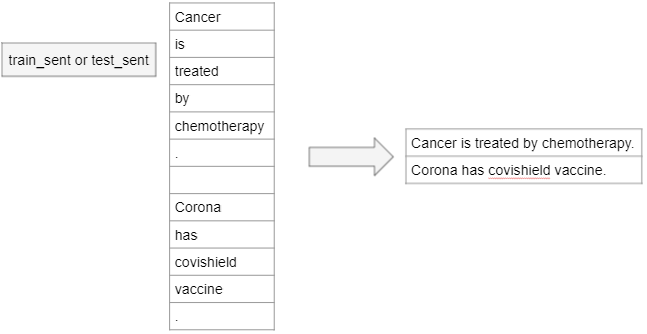

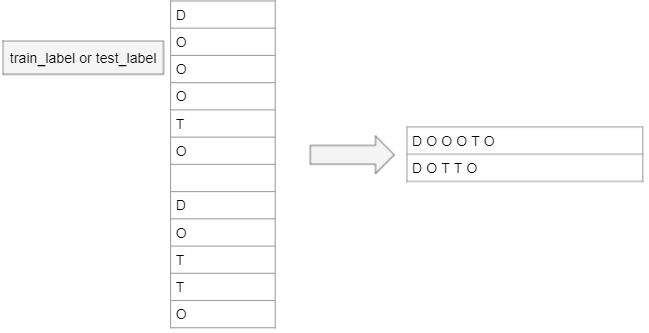

In [5]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = f.read()
    return data.strip()


# Preprocess the data and construct sentences
def preprocess_data(data):
    sentences = []
    current_sentence = []

    for line in data.split('\n'):
        # If the line is empty and we have collected a sentence
        if line.strip() == "":
            if current_sentence:
                sentences.append(current_sentence)
                current_sentence = []
        else:
            current_sentence.append(line.strip())

    # Add the last sentence if there's no trailing newline
    if current_sentence:
        sentences.append(current_sentence)

    return sentences


# Load the dataset
file_path = 'train_sent'  # Replace with your file path
raw_data = load_data(file_path)

# Preprocess the data to construct sentences
sentences = preprocess_data(raw_data)

# Print the first 5 sentences
for i, sentence in enumerate(sentences[:5]):
    print(f"Sentence {i + 1}: {' '.join(sentence)}")


Sentence 1: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Sentence 2: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Sentence 3: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Sentence 4: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Sentence 5: Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


### Count the number of sentences in the processed train and test dataset 

In [6]:
# Load the datasets
train_file_path = 'train_sent'
test_file_path = 'test_sent'

# Load and preprocess the train dataset
train_raw_data = load_data(train_file_path)
train_sentences = preprocess_data(train_raw_data)

# Load and preprocess the test dataset
test_raw_data = load_data(test_file_path)
test_sentences = preprocess_data(test_raw_data)

# Count the number of sentences
num_train_sentences = len(train_sentences)
num_test_sentences = len(test_sentences)

# Print the counts
print(f"Number of sentences in the training dataset: {num_train_sentences}")
print(f"Number of sentences in the testing dataset: {num_test_sentences}")


Number of sentences in the training dataset: 2599
Number of sentences in the testing dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [7]:

# Load the datasets
train_labels_file_path = 'train_label' 
test_labels_file_path = 'test_label'

# Load and preprocess the train dataset
train_labels_raw_data = load_data(train_labels_file_path)
train_labels = preprocess_data(train_labels_raw_data)

# Load and preprocess the test dataset
test_labels_raw_data = load_data(test_labels_file_path)
test_labels = preprocess_data(test_labels_raw_data)

# Count the number of sentences
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

# Print the counts
print(f"Number of labels in the training dataset: {num_train_labels}")
print(f"Number of labels in the testing dataset: {num_test_labels}")

Number of labels in the training dataset: 2599
Number of labels in the testing dataset: 1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [8]:
import spacy
from collections import Counter

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")


# Process sentences and extract NOUN and PROPN tokens
def extract_noun_prop_tokens(sentences):
    # Create a list to hold all noun and proper noun tokens
    noun_prop_tokens = []

    for sentence in sentences:
        doc = nlp(' '.join(sentence))  # Process the sentence with spaCy
        # Extract tokens with PoS tags NOUN or PROPN
        for token in doc:
            if token.pos_ in ['NOUN', 'PROPN']:
                noun_prop_tokens.append(token.text)

    return noun_prop_tokens


# Extract noun and proper noun tokens from the training sentences
noun_prop_tokens = extract_noun_prop_tokens(train_sentences)

# Count the frequency of each token
token_frequencies = Counter(noun_prop_tokens)

# Print the frequencies
print("NOUN and PROPN Frequencies:")
for token, freq in token_frequencies.items():
    print(f"{token}: {freq}")

NOUN and PROPN Frequencies:
births: 1
weeks: 27
University: 6
Vermont: 1
delivery: 18
route: 2
indication: 3
age: 34
parity: 1
practice: 22
group: 63
risk: 49
status: 14
rate: 46
%: 161
presentation: 6
medicine: 29
patients: 354
Arrest: 1
dilation: 1
subgroups: 1
rates: 22
care: 47
hospitals: 8
community: 11
groups: 23
trimester: 4
fluid: 5
index: 11
AFI: 5
temperature: 5
increases: 6
decrease: 3
June: 2
August: 5
period: 22
heat: 2
women: 48
singleton: 1
pregnancies: 7
gestation: 4
testing: 15
determinations: 2
ambient: 1
area: 8
day: 27
mean: 1
test: 15
date: 2
Spearman: 1
rank: 1
Correlation: 3
relationship: 9
account: 4
measure: 3
well: 2
being: 2
study: 103
population: 23
diabetes: 23
screening: 10
clinic: 4
Hadassah: 1
Medical: 5
Center: 3
year: 27
treatment: 195
week: 6
protocol: 5
control: 30
characteristics: 14
differences: 13
mode: 3
Apgar: 1
scores: 4
infants: 17
cases: 46
aim: 7
contribution: 3
markers: 18
diagnosis: 40
fetuses: 6
years: 45
syndrome: 45
Edward: 2
trisomies:

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [9]:
import spacy
from collections import Counter

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")


# Process sentences and extract NOUN and PROPN tokens
def extract_noun_prop_tokens(sentences):
    noun_prop_tokens = []

    for sentence in sentences:
        doc = nlp(' '.join(sentence))  # Process the sentence with spaCy
        # Extract tokens with PoS tags NOUN or PROPN
        for token in doc:
            if token.pos_ in ['NOUN', 'PROPN']:
                noun_prop_tokens.append(token.text)

    return noun_prop_tokens


# Extract noun and proper noun tokens from the training sentences
noun_prop_tokens = extract_noun_prop_tokens(train_sentences)

# Count the frequency of each token
token_frequencies = Counter(noun_prop_tokens)

# Get the top 25 most common tokens
top_25_tokens = token_frequencies.most_common(25)

# Print the top 25 most common tokens
print("Top 25 NOUN and PROPN Tokens:")
for token, freq in top_25_tokens:
    print(f"{token}: {freq}")


Top 25 NOUN and PROPN Tokens:
patients: 354
treatment: 195
%: 161
cancer: 135
therapy: 120
disease: 105
study: 103
cell: 99
lung: 87
chemotherapy: 65
group: 63
effects: 61
gene: 54
results: 54
TO_SEE: 54
use: 53
surgery: 51
survival: 50
risk: 49
women: 48
care: 47
analysis: 47
children: 47
activity: 47
rate: 46


## Defining features for CRF





In [10]:
# Define the features to get the feature value for one word.
def word_features(sentence, index):
    """Extract features for a word in a given sentence."""
    word = sentence[index]
    features = {
        'word': word,
        'word.lower()': word.lower(),
        'word[-2:]': word[-2:],
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'length': len(word),
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1
    }

    # Previous word features
    if index > 0:
        prev_word = sentence[index - 1]
        features.update({
            'prev_word': prev_word,
            'prev_word.lower()': prev_word.lower(),
            'prev_word.isupper()': prev_word.isupper(),
            'prev_word.istitle()': prev_word.istitle()
        })
    else:
        features['prev_word'] = '<START>'

    # Next word features
    if index < len(sentence) - 1:
        next_word = sentence[index + 1]
        features.update({
            'next_word': next_word,
            'next_word.lower()': next_word.lower(),
            'next_word.isupper()': next_word.isupper(),
            'next_word.istitle()': next_word.istitle()
        })
    else:
        features['next_word'] = '<END>'

    return features


example_sentence = train_sentences[0]
features_list = [word_features(example_sentence, i) for i in range(len(example_sentence))]

# Print features for each word
for i, features in enumerate(features_list):
    print(f"Features for '{example_sentence[i]}':")
    for key, value in features.items():
        print(f"  {key}: {value}")


Features for 'All':
  word: All
  word.lower(): all
  word[-2:]: ll
  word[-3:]: All
  word.isupper(): False
  word.istitle(): True
  word.isdigit(): False
  length: 3
  is_first: True
  is_last: False
  prev_word: <START>
  next_word: live
  next_word.lower(): live
  next_word.isupper(): False
  next_word.istitle(): False
Features for 'live':
  word: live
  word.lower(): live
  word[-2:]: ve
  word[-3:]: ive
  word.isupper(): False
  word.istitle(): False
  word.isdigit(): False
  length: 4
  is_first: False
  is_last: False
  prev_word: All
  prev_word.lower(): all
  prev_word.isupper(): False
  prev_word.istitle(): True
  next_word: births
  next_word.lower(): births
  next_word.isupper(): False
  next_word.istitle(): False
Features for 'births':
  word: births
  word.lower(): births
  word[-2:]: hs
  word[-3:]: ths
  word.isupper(): False
  word.istitle(): False
  word.isdigit(): False
  length: 6
  is_first: False
  is_last: False
  prev_word: live
  prev_word.lower(): live
  prev

## Getting the features

### Write a code/function to get the features for a sentence

In [11]:
# Extract features for all words in a given sentence.
def get_sentence_features(sentence):
    features = []
    for index in range(len(sentence)):
        word_feats = word_features(sentence, index)
        features.append(word_feats)
    return features


features_for_sentence = get_sentence_features(example_sentence)

# Print features for the entire sentence
for i, features in enumerate(features_for_sentence):
    print(f"Features for '{example_sentence[i]}':")
    for key, value in features.items():
        print(f"  {key}: {value}")

Features for 'All':
  word: All
  word.lower(): all
  word[-2:]: ll
  word[-3:]: All
  word.isupper(): False
  word.istitle(): True
  word.isdigit(): False
  length: 3
  is_first: True
  is_last: False
  prev_word: <START>
  next_word: live
  next_word.lower(): live
  next_word.isupper(): False
  next_word.istitle(): False
Features for 'live':
  word: live
  word.lower(): live
  word[-2:]: ve
  word[-3:]: ive
  word.isupper(): False
  word.istitle(): False
  word.isdigit(): False
  length: 4
  is_first: False
  is_last: False
  prev_word: All
  prev_word.lower(): all
  prev_word.isupper(): False
  prev_word.istitle(): True
  next_word: births
  next_word.lower(): births
  next_word.isupper(): False
  next_word.istitle(): False
Features for 'births':
  word: births
  word.lower(): births
  word[-2:]: hs
  word[-3:]: ths
  word.isupper(): False
  word.istitle(): False
  word.isdigit(): False
  length: 6
  is_first: False
  is_last: False
  prev_word: live
  prev_word.lower(): live
  prev

### Write a code/function to get the labels of a sentence

In [12]:
# Write a code to get the labels for a sentence.
def get_sentence_labels(sentence, labels):
    """Extract labels for all words in a given sentence."""
    if len(sentence) != len(labels):
        raise ValueError("The length of the sentence and labels must be the same.")

    return labels  # Directly return labels as they align with the sentence words

example_sentence = train_sentences[0]
example_label = train_labels[0]

labels_for_sentence = get_sentence_labels(example_sentence, example_label)

# Print labels for the entire sentence
for i, label in enumerate(labels_for_sentence):
    print(f"Label for '{example_sentence[i]}': {label}")

Label for 'All': O
Label for 'live': O
Label for 'births': O
Label for '>': O
Label for 'or': O
Label for '=': O
Label for '23': O
Label for 'weeks': O
Label for 'at': O
Label for 'the': O
Label for 'University': O
Label for 'of': O
Label for 'Vermont': O
Label for 'in': O
Label for '1995': O
Label for '(': O
Label for 'n': O
Label for '=': O
Label for '2395': O
Label for ')': O
Label for 'were': O
Label for 'retrospectively': O
Label for 'analyzed': O
Label for 'for': O
Label for 'delivery': O
Label for 'route': O
Label for ',': O
Label for 'indication': O
Label for 'for': O
Label for 'cesarean': O
Label for ',': O
Label for 'gestational': O
Label for 'age': O
Label for ',': O
Label for 'parity': O
Label for ',': O
Label for 'and': O
Label for 'practice': O
Label for 'group': O
Label for '(': O
Label for 'to': O
Label for 'reflect': O
Label for 'risk': O
Label for 'status': O
Label for ')': O


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [13]:
# Extract features and labels for a list of sentences.
def extract_features_and_labels(sentences, labels):
    X = []  # Feature matrix
    Y = []  # Label matrix

    for sentence, label_seq in zip(sentences, labels):
        features = get_sentence_features(sentence)  # Get features for the sentence
        X.append(features)  # Append the features to the feature matrix
        Y.append(label_seq)  # Append the labels to the label matrix

    return X, Y


# Extract features and labels for training data
X_train, Y_train = extract_features_and_labels(train_sentences, train_labels)

# Extract features and labels for test data
X_test, Y_test = extract_features_and_labels(test_sentences, test_labels)

# Print the shapes of the matrices to ensure correctness
print(f"Training feature matrix shape: {len(X_train)} sentences with {len(X_train[0])} features each.")
print(f"Training label matrix shape: {len(Y_train)} sentences.")
print(f"Test feature matrix shape: {len(X_test)} sentences with {len(X_test[0])} features each.")
print(f"Test label matrix shape: {len(Y_test)} sentences.")


Training feature matrix shape: 2599 sentences with 45 features each.
Training label matrix shape: 2599 sentences.
Test feature matrix shape: 1056 sentences with 44 features each.
Test label matrix shape: 1056 sentences.


### Define the labels as the target variable for test and the train dataset

In [14]:
# Defining the target variable for training and test datasets
Y_train = train_labels  # Target labels for training data
Y_test = test_labels  # Target labels for test data

# Display the count of unique labels and a few examples to verify
unique_train_labels = set(label for seq in Y_train for label in seq)
unique_test_labels = set(label for seq in Y_test for label in seq)

print(f"Number of unique labels in training dataset: {len(unique_train_labels)}")
print(f"Unique labels in training dataset: {unique_train_labels}")
print(f"Number of unique labels in test dataset: {len(unique_test_labels)}")
print(f"Unique labels in test dataset: {unique_test_labels}")

# Ensure the lengths of Y_train and Y_test match the number of sentences
print(f"Number of sentences in training dataset: {len(Y_train)}")
print(f"Number of sentences in test dataset: {len(Y_test)}")


Number of unique labels in training dataset: 3
Unique labels in training dataset: {'O', 'T', 'D'}
Number of unique labels in test dataset: 3
Unique labels in test dataset: {'O', 'T', 'D'}
Number of sentences in training dataset: 2599
Number of sentences in test dataset: 1056


## Build the CRF Model

In [15]:
# Build the CRF model.
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Step 1: Initialize the CRF Model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,  # L1 penalty
    c2=0.1,  # L2 penalty
    max_iterations=100,
    all_possible_transitions=True
)

# Step 2: Train the Model
crf.fit(X_train, Y_train)

# Step 3: Make Predictions on the Test Data
Y_pred = crf.predict(X_test)

# Step 4: Evaluate the Model
# Use metrics such as classification report and accuracy
print("Classification Report:")
labels = list(set(label for sublist in Y_train for label in sublist))
print(metrics.flat_classification_report(Y_test, Y_pred, labels=labels))

# Calculate additional metrics
accuracy = metrics.flat_accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

           O       0.95      0.98      0.96     16127
           T       0.77      0.59      0.67      1041
           D       0.81      0.64      0.72      1450

    accuracy                           0.93     18618
   macro avg       0.84      0.74      0.78     18618
weighted avg       0.92      0.93      0.93     18618

Accuracy: 0.9290


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [16]:
# Step 1: Predict the labels for the test dataset
Y_pred = crf.predict(X_test)

# Step 2: Print the tokens along with their predicted labels
for sentence, predicted_labels in zip(test_sentences, Y_pred):
    print("Tokens and Predicted Labels:")
    for token, label in zip(sentence, predicted_labels):
        print(f"{token}: {label}")
    print()


Tokens and Predicted Labels:
Furthermore: O
,: O
when: O
all: O
deliveries: O
were: O
analyzed: O
,: O
regardless: O
of: O
risk: O
status: O
but: O
limited: O
to: O
gestational: O
age: O
>: O
or: O
=: O
36: O
weeks: O
,: O
the: O
rates: O
did: O
not: O
change: O
(: O
12.6: O
%: O
,: O
280: O
of: O
2214: O
;: O
primary: O
9.2: O
%: O
,: O
183: O
of: O
1994: O
): O

Tokens and Predicted Labels:
As: O
the: O
ambient: O
temperature: O
increases: O
,: O
there: O
is: O
an: O
increase: O
in: O
insensible: D
fluid: D
loss: D
and: O
the: O
potential: O
for: O
dehydration: O

Tokens and Predicted Labels:
The: O
daily: O
high: O
temperature: O
ranged: O
from: O
71: O
to: O
104: O
degrees: O
F: O
and: O
AFI: O
values: O
ranged: O
from: O
1.7: O
to: O
24.7: O
cm: O
during: O
the: O
study: O
period: O

Tokens and Predicted Labels:
There: O
was: O
a: O
significant: O
correlation: O
between: O
the: O
2-: O
,: O
3-: O
,: O
and: O
4-day: O
mean: O
temperature: O
and: O
AFI: O
,: O
with: O
the: O
4-day: 

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [17]:
from sklearn import metrics

# Flatten the list of actual labels and predicted labels
y_true_flat = [label for sentence in Y_test for label in sentence]
y_pred_flat = [label for sentence in Y_pred for label in sentence]

# Calculate F1 score
f1_score = metrics.f1_score(y_true_flat, y_pred_flat, average='weighted')

# Print the F1 score
print(f"F1 Score: {f1_score:.4f}")


F1 Score: 0.9253


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



In [18]:
diseases = []
treatments = []

for sentence, labels in zip(test_sentences, Y_pred):
    disease_list = []
    treatment_list = []
    for token, label in zip(sentence, labels):
        if label == 'D':
            disease_list.append(token)
        elif label == 'T':
            treatment_list.append(token)
    if disease_list:
        diseases.append(' '.join(disease_list))
    if treatment_list:
        treatments.append(' '.join(treatment_list))
        
for disease, treatment in zip(diseases, treatments):
    print(f"Disease: {disease}, Treatment: {treatment}")

Disease: insensible fluid loss, Treatment: good glycemic control
Disease: macrosomic infants in gestational diabetes cases, Treatment: radiotherapy
Disease: microcephaly fetalis, Treatment: methylphenidate
Disease: preeclampsia, Treatment: Methylphenidate
Disease: preeclampsia, Treatment: aspirin , 3 mg warfarin with 80 mg aspirin , or 1 mg warfarin with 80 mg aspirin
Disease: asymmetric double hemiplegia, Treatment: aspirin warfarin with 80 mg aspirin warfarin with 80 mg aspirin
Disease: fetalis, Treatment: warfarin
Disease: cancer, Treatment: roxithromycin
Disease: breast cancer breast cancer ovarian cancer, Treatment: Antichlamydial antibiotics
Disease: prostate cancer, Treatment: radical radiotherapy
Disease: prostate cancer, Treatment: beta human chorionic gondotropin
Disease: prostate cancer, Treatment: electrical nerve stimulation electrical muscle stimulation ( EMS ) therapy
Disease: multiple sclerosis, Treatment: surgical correction
Disease: retinoblastoma, Treatment: dexfenfl

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

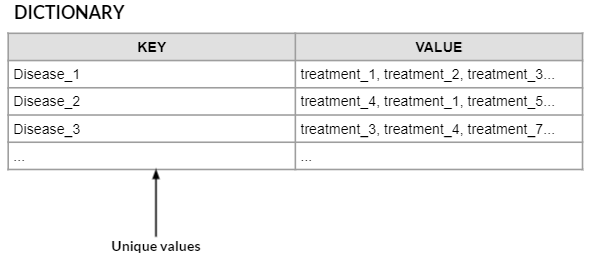

In [19]:
diseases_treatments = []

for sentence, true_labels, predicted_labels in zip(test_sentences, Y_test, Y_pred):
    disease_list = []
    treatment_list = []
    for token, true_label, predicted_label in zip(sentence, true_labels, predicted_labels):
        if predicted_label == 'D':
            disease_list.append(token)
        elif predicted_label == 'T':
            treatment_list.append(token)
    if disease_list:
        diseases_treatments.append((disease_list, treatment_list))

for disease, treatment in diseases_treatments:
    print(f"Disease: {' '.join(disease)}, Treatment: {' '.join(treatment)}")

Disease: insensible fluid loss, Treatment: 
Disease: macrosomic infants in gestational diabetes cases, Treatment: good glycemic control
Disease: microcephaly fetalis, Treatment: 
Disease: preeclampsia, Treatment: 
Disease: preeclampsia, Treatment: 
Disease: asymmetric double hemiplegia, Treatment: 
Disease: fetalis, Treatment: 
Disease: cancer, Treatment: 
Disease: breast cancer breast cancer ovarian cancer, Treatment: 
Disease: prostate cancer, Treatment: 
Disease: prostate cancer, Treatment: 
Disease: prostate cancer, Treatment: 
Disease: multiple sclerosis, Treatment: 
Disease: retinoblastoma, Treatment: radiotherapy
Disease: pericardial effusions, Treatment: 
Disease: epilepsy ADHD, Treatment: Methylphenidate
Disease: unstable angina or non-Q-wave myocardial infarction, Treatment: roxithromycin
Disease: coronary-artery disease, Treatment: Antichlamydial antibiotics
Disease: early-stage cervical carcinoma, Treatment: 
Disease: colon tumors, Treatment: 
Disease: cerebral palsy, Treat

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [20]:
disease_name = 'hereditary retinoblastoma'
predicted_treatment = []

for sentence, predicted_labels in zip(test_sentences, Y_pred):
    sentence_text = ' '.join(sentence)
    if disease_name in sentence_text:
        for token, predicted_label in zip(sentence, predicted_labels):
            if predicted_label == 'T':
                predicted_treatment.append(token)

predicted_treatment_text = ' '.join(predicted_treatment)
print(f"The predicted treatment for the disease '{disease_name}' is: {predicted_treatment_text}")

The predicted treatment for the disease 'hereditary retinoblastoma' is: radiotherapy
